# Neural Network 

In [17]:
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Input

import os
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np 
import seaborn as sns
import importlib


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold ,cross_val_score

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from src.utils.config import Config
from src.visualization import visualize
from src.data import make_dataset
from src.features import build_features
from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model


sns.set(
    style='whitegrid',
    font_scale=1.5
)

plt.style.use('ggplot')

In [14]:
labled_data_set,expression_level,labels,true_labels= make_dataset.get_data("original")
labled_data_set_sd,expression_level_sd,labels,true_labels= make_dataset.get_data("standardized")



In [7]:
labels_array= labels["Class"].values


[]

In [8]:
Y_encoded = []
for i in labels_array :
    if i == 'PRAD' : Y_encoded.append(0)
    if i == 'LUAD': Y_encoded.append(1)
    if i == 'BRCA' : Y_encoded.append(2)
    if i == 'KIRC': Y_encoded.append(3)
    if i == 'COAD': Y_encoded.append(4)

Y_bis = to_categorical(Y_encoded)
Y_bis

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(expression_level, Y_bis, test_size=0.33, random_state=42,stratify=labels_array )
X_train.shape

(536, 20531)

# Feature Extraction 

since we have a tremendous number of features , we opt for the transformed data we generated from notebook 01 , we will start by the dataset HGV (highly variable genes ) containing only top 5000 with the highest variance with respect to mean .
Then we will develop an autoencoder to learn a compressed representation of the input features for a classification predictive modeling problem. 

In [15]:
HGV,PCA,UMAP,TSNA = make_dataset.get_transformed_data()
HGV.shape

(801, 5000)

## Autoencoder

In [19]:
HGV=HGV.iloc[:,:50]

# number of input columns
n_inputs = HGV.shape[1]
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(HGV, labels_array, test_size=0.33, random_state=1)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

2022-01-07 19:45:00.068077: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-07 19:45:00.069523: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 200000000 exceeds 10% of free system memory.
2022-01-07 19:45:00.130624: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 200000000 exceeds 10% of free system memory.
2022-01-07 19:45:00.150299: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 200000000 exceeds 10% of free system memory.
2022-01-07 19:45:00.209661: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 200000000 exceeds 10% of free system memory.
2022-01-07 19:45:00.265810: W tensorflow/core/framework/cpu_allocator_impl.c

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/200


2022-01-07 19:45:00.819427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-07 19:45:00.839955: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


34/34 - 28s - loss: 0.5336 - val_loss: 30.5548
Epoch 2/200
34/34 - 26s - loss: 0.0997 - val_loss: 0.9980
Epoch 3/200
34/34 - 27s - loss: 0.1036 - val_loss: 0.2404
Epoch 4/200


KeyboardInterrupt: 

In [23]:
HGV=HGV.iloc[:,:50]
HGV.shape

(801, 50)

# The model 

In [9]:
init = 'random_uniform'
input_layer = Input(shape=(30,))
mid_layer = Dense(15, activation = 'relu', kernel_initializer = init)(input_layer)
mid_layer_2 = Dense(8, activation = 'relu', kernel_initializer = init)(mid_layer)
output_layer = Dense(5, activation = 'softmax', kernel_initializer = init)(mid_layer_2)

2021-11-04 15:06:39.596223: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model = Model(input_layer,output_layer)
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 15)                465       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


In [11]:
import numpy as np
z=model.predict(X_test)

2021-11-04 15:06:39.867476: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-04 15:06:39.887656: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


In [12]:
z_arg=np.argmax(z,axis=1)
z_arg

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
y_test[:10]
y_arg=np.argmax(y_test,axis=1)
y_arg

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [14]:
pd.crosstab(y_arg,z_arg)

col_0,1
row_0,
0,70
1,118


In [15]:
z
X_train, X_test, y_train, y_test = train_test_split(X, Y_bis, test_size=0.33, random_state=42,stratify=Y )
model.fit(X_train,y_train, batch_size=32, epochs=100, verbose=1)

Epoch 1/100
12/12 [==============================] - 0s 678us/step - loss: 0.6964 - accuracy: 0.6576
Epoch 2/100
12/12 [==============================] - 0s 656us/step - loss: 0.6871 - accuracy: 0.7249
Epoch 3/100
12/12 [==============================] - 0s 831us/step - loss: 0.6771 - accuracy: 0.4700
Epoch 4/100
12/12 [==============================] - 0s 918us/step - loss: 0.6609 - accuracy: 0.5648
Epoch 5/100
12/12 [==============================] - 0s 760us/step - loss: 0.6493 - accuracy: 0.5533
Epoch 6/100
12/12 [==============================] - 0s 898us/step - loss: 0.6134 - accuracy: 0.5632
Epoch 7/100
12/12 [==============================] - 0s 925us/step - loss: 0.6427 - accuracy: 0.6337
Epoch 8/100
12/12 [==============================] - 0s 636us/step - loss: 0.6215 - accuracy: 0.5616
Epoch 9/100
12/12 [==============================] - 0s 747us/step - loss: 0.5876 - accuracy: 0.6827
Epoch 10/100
12/12 [==============================] - 0s 688us/step - loss: 0.6103 - accura

In [23]:
from sklearn.metrics import accuracy_score
training_accuracy =[]
testing_accuracy =[]
for i in range(1,100):
    model.fit(X_train,y_train, batch_size=32, epochs=i, verbose=1)
    
    pred_x_test=np.argmax( (model.predict(X_test))  , axis=1)
    y_test_acc =np.argmax(y_test,axis=1)

    pred_x_train=np.argmax( (model.predict(X_train))  , axis=1)
    y_train_acc =np.argmax(y_train,axis=1) 
    training_accuracy.append(accuracy_score(pred_x_test,y_test_acc))
    testing_accuracy.append(accuracy_score(pred_x_train,y_train_acc))

12/12 [==============================] - 0s 780us/step - loss: 0.1571 - accuracy: 0.9344
Epoch 1/2
12/12 [==============================] - 0s 696us/step - loss: 0.1620 - accuracy: 0.9318
Epoch 2/2
12/12 [==============================] - 0s 661us/step - loss: 0.1845 - accuracy: 0.9291
Epoch 1/3
12/12 [==============================] - 0s 740us/step - loss: 0.1663 - accuracy: 0.9344
Epoch 2/3
12/12 [==============================] - 0s 756us/step - loss: 0.1664 - accuracy: 0.9344
Epoch 3/3
12/12 [==============================] - 0s 655us/step - loss: 0.1719 - accuracy: 0.9318
Epoch 1/4
12/12 [==============================] - 0s 575us/step - loss: 0.1952 - accuracy: 0.9239
Epoch 2/4
12/12 [==============================] - 0s 610us/step - loss: 0.1734 - accuracy: 0.9239
Epoch 3/4
12/12 [==============================] - 0s 741us/step - loss: 0.1639 - accuracy: 0.9344
Epoch 4/4
12/12 [==============================] - 0s 739us/step - loss: 0.1685 - accuracy: 0.9265
Epoch 1/5
12/12 [===

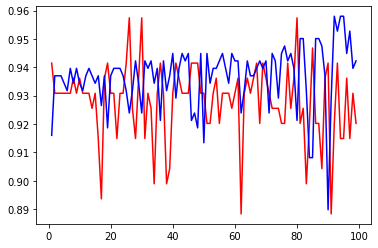

In [24]:
import math
import matplotlib.pyplot as plt
t = range(1,100)
a = training_accuracy
b = testing_accuracy
plt.plot(t, a, 'r') # plotting t, a separately
plt.plot(t, b, 'b') # plotting t, b separately
plt.show()